# Confirming cleavage heterogeneity mechanisms *in silico*
## Upstream UA-rich elements

**Purpose**: To systematically investigate the factors controlling site heterogeneity in targeted examples.


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%run -i notebook_setup.py

## IMPORTS AND SETUP

In [4]:
from paper_utilities import cleavage

In [5]:
PROJECT = "/projects/b1080/eks/polyadenylation/yeast"
CLVDIR  = os.path.join(PROJECT, 'saccharomyces_cerevisiae', 'analysis', 'motif_analysis', 'entropy_motif_conversion', '20240423-152708_epoch-29')
OUTDIR  = os.path.join(PROJECT, 'manuscript', 'analysis', 'cleavage_mechanisms')
RESOURCES = os.path.join(os.path.dirname(OUTDIR), 'resources')
os.makedirs(OUTDIR, exist_ok = True)


In [6]:
with open(os.path.join(RESOURCES, 'gold_data.cleavage_heterogeneity.ctr.pickle'), mode = 'rb') as handle:
    gold_tpdata = pickle.load(handle)

print(gold_tpdata.shape)


(11400, 457)


## ANALYSIS

## Mechanism 2: Multiplicity of upstream efficiency elements

### Removing upstream UA/UA-rich motifs in high entropy sites

In [7]:
hi_mult_data = pd.read_csv(os.path.join(CLVDIR, 'uaua_multiplicity.high_entropy_disruption.txt'), 
                           sep = "\t", names = ['testID','index','iteration','category','sequence','count','indices','absolutePosition','relativePosition','testMotif','cleavageVector'])

print(hi_mult_data.shape)


## Process string vectors into numeric numpy arrays

hi_mult_data['indices']         = hi_mult_data['indices'].apply(lambda x : np.asarray([float(_) for _ in x.strip("][").split(", ")] if (x != "[]") else np.asarray([])))
hi_mult_data['cleavageVector']  = hi_mult_data['cleavageVector'].apply(lambda x : np.asarray([float(_) for _ in x.strip("][").split(", ")]))
hi_mult_data['cleavageEntropy'] = hi_mult_data['cleavageVector'].apply(lambda x : cleavage.calculate_entropy_from_vector(x))


## Identify original and replaced cleavage sites

original_hi_mult_data = hi_mult_data.loc[hi_mult_data['category'] == 'Original'].copy()
converted_hi_mult_data = hi_mult_data.loc[hi_mult_data['category'] == 'Removed'].copy()

print(original_hi_mult_data.shape)
print(converted_hi_mult_data.shape)


## Match the number of U- and UA/UA-rich motifs in the region of interest

mdict = dict(zip(gold_tpdata['label'], gold_tpdata['consensus_entropy']))
converted_hi_mult_data['consensusEntropy'] = converted_hi_mult_data['testID'].apply(lambda x : mdict[x])

mdict = dict(zip(gold_tpdata['label'], gold_tpdata['count_UA_d2_-90_-30']))
converted_hi_mult_data['originalCountUA'] = converted_hi_mult_data['testID'].apply(lambda x : mdict[x])
converted_hi_mult_data['removedCountUA'] = converted_hi_mult_data['count'] - converted_hi_mult_data['originalCountUA']


## Calculate the change in entropy after motif conversion

edict = dict(zip(original_hi_mult_data['testID'], original_hi_mult_data['cleavageEntropy']))

converted_hi_mult_data['originalEntropy'] = converted_hi_mult_data['testID'].apply(lambda x: edict[x])
converted_hi_mult_data['fcEntropy']       = converted_hi_mult_data.apply(lambda row: row['cleavageEntropy'] / row['originalEntropy'], axis = 1)
converted_hi_mult_data['deltaEntropy']    = converted_hi_mult_data.apply(lambda row: row['cleavageEntropy'] - row['originalEntropy'], axis = 1)

print(converted_hi_mult_data['consensusEntropy'].value_counts())
print(converted_hi_mult_data['deltaEntropy'].describe())


(152805, 11)
(305, 12)
(152500, 12)
True    152500
Name: consensusEntropy, dtype: int64
count    152500.000000
mean         -0.070241
std           0.171078
min          -1.467077
25%          -0.137647
50%          -0.028691
75%           0.016886
max           0.562066
Name: deltaEntropy, dtype: float64


In [8]:
maxUA = 5

cond0 = (converted_hi_mult_data['consensusEntropy'] == True)
cond1 = (converted_hi_mult_data['originalCountUA'] == maxUA)
cond2 = (converted_hi_mult_data['count'].between(1,maxUA))

condPLOT = (cond0 & cond1 & cond2)
print(cond0.sum(), cond1.sum(), cond2.sum(), condPLOT.sum())

plot_data = converted_hi_mult_data.loc[condPLOT]
plot_data['testLabel'] = plot_data['testID'] + ':' + plot_data['iteration'].astype(str)
print(plot_data['testID'].nunique(), plot_data[['testID','index']].drop_duplicates().shape)

wide_data = pd.pivot(plot_data, index = 'testLabel', columns = 'removedCountUA', values = 'deltaEntropy')
wide_data.columns = wide_data.columns.map(str)
print(wide_data.shape, wide_data.isna().any(axis = 1).sum())


152500 152500 122000 122000
305 (305, 2)
(30500, 4) 0


notebook_setup.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from collections import defaultdict


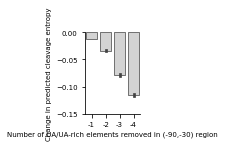


Corresponding statistics-
	Wilcoxon signed-rank paired test (group 1 vs -4): 102104739.000 0.00E+00
	Wilcoxon signed-rank paired test (group 1 vs -3): 103234944.000 0.00E+00
	Wilcoxon signed-rank paired test (group 1 vs -2): 148159096.000 0.00E+00

Summary data-
                count    median      mean       std       min       max
removedCountUA                                                         
-4              30500 -0.091487 -0.115495  0.209983 -1.396595  0.496401
-3              30500 -0.054231 -0.078531  0.151657 -1.162122  0.431394
-2              30500 -0.018096 -0.034029  0.097998 -0.537145  0.370739
-1              30500 -0.004836 -0.012191  0.057783 -0.384270  0.317914


In [9]:
fig,ax = plt.subplots(1,1, figsize = (1,1.5))

x = 'removedCountUA'
y = 'deltaEntropy'

sns.barplot(data = plot_data, x = x, y = y, order = np.arange(1-maxUA,0,1)[::-1],
            color = 'lightgray', edgecolor = 'black', linewidth = 0.5,
            ax = ax)

ax.set_xlabel("Number of UA/UA-rich elements removed in (-90,-30) region")

ax.set_ylabel("Change in predicted cleavage entropy")
ax.set_ylim(-0.15,0)
ax.yaxis.set_major_locator(MultipleLocator(0.05))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'entropy_mechanisms.uaua_multiplicity.high_entropy.barplot.{y}_by_{x}.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("\nCorresponding statistics-")

for c in wide_data.columns:

    if (c == '-1'):
        continue
        
    stat, pval = st.wilcoxon(wide_data[c], wide_data['-1'])
    print(f"\tWilcoxon signed-rank paired test (group 1 vs {c}): {stat:12.03f} {pval:8.02E}")

print("\nSummary data-")
print(plot_data.groupby(x)[y].agg(['count','median','mean','std','min','max']))


### Individual examples

#### Example 1

Gene=YPR114W, observed_entropy=2.93499793201725
Max normalized cleavage prediction: 0.2712160050868988
77154 GCATATATGTGTATATAGACTATAAACTTGTGTAAGCTATGCGAGCATTACAAACCTAGAAAATTACAGG 3.114552340308029 5 [163.0, 169.0, 176.0, 183.0, 189.0]
77570 GCATATATCATCCCATAGACTATAAACTTGTGTAAGCTATGCGAGCATTACAAACCTAGAAAATTACAGG 2.821238626982844 4 [169.0, 176.0, 183.0, 189.0]
77571 GCATATATCATCCCGAGACTTATAAACTTGTGTAAGCTATGCGAGCATTACAAACCTAGAAAATTACAGG 2.703223273594543 3 [176.0, 183.0, 189.0]
77572 GCATATATCATCCCGAGACTTCTGCTATTGTGTAAGCTATGCGAGCATTACAAACCTAGAAAATTACAGG 2.5323884827165473 2 [183.0, 189.0]
77573 GCATATATCATCCCGAGACTTCTGCTATTTTACTAGCTATGCGAGCATTACAAACCTAGAAAATTACAGG 2.3280616001017895 1 [189.0]


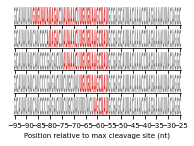

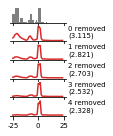

In [11]:
maxUA = 5
rs = 1237872138
example_id = "005758:XVI:754368:+"
example_iter = 84


## Print site information and cleavage entropy data

example_gene    = gold_tpdata.loc[gold_tpdata['label'] == example_id, 'gene'].iloc[0]
example_obsent  = gold_tpdata.loc[gold_tpdata['label'] == example_id, 'observed_entropy'].iloc[0]
example_maxclv  = gold_tpdata.loc[gold_tpdata['label'] == example_id, 'ctr_cleavage'].iloc[0]
example_readvec = gold_tpdata.loc[gold_tpdata['label'] == example_id, 'readvec'].iloc[0]
print(f"Gene={example_gene}, observed_entropy={example_obsent}")

example_bin0 = hi_mult_data.loc[(hi_mult_data['testID'] == example_id) & (hi_mult_data['iteration'] == 0)            & (hi_mult_data['count'] == maxUA)].sample(1, random_state = rs).iloc[0]
example_bin1 = hi_mult_data.loc[(hi_mult_data['testID'] == example_id) & (hi_mult_data['iteration'] == example_iter) & (hi_mult_data['count'] == maxUA-1)].sample(1, random_state = rs).iloc[0]
example_bin2 = hi_mult_data.loc[(hi_mult_data['testID'] == example_id) & (hi_mult_data['iteration'] == example_iter) & (hi_mult_data['count'] == maxUA-2)].sample(1, random_state = rs).iloc[0]
example_bin3 = hi_mult_data.loc[(hi_mult_data['testID'] == example_id) & (hi_mult_data['iteration'] == example_iter) & (hi_mult_data['count'] == maxUA-3)].sample(1, random_state = rs).iloc[0]
example_bin4 = hi_mult_data.loc[(hi_mult_data['testID'] == example_id) & (hi_mult_data['iteration'] == example_iter) & (hi_mult_data['count'] == maxUA-4)].sample(1, random_state = rs).iloc[0]

example_bin_max = max([max(x['cleavageVector']) for x in [example_bin0, example_bin1, example_bin2, example_bin3, example_bin4]])
print(f"Max normalized cleavage prediction: {example_bin_max}")

for e in [example_bin0, example_bin1, example_bin2, example_bin3, example_bin4]:
    print(e.name, e['sequence'][int(example_maxclv-95):int(example_maxclv-25)], e['cleavageEntropy'], e['count'], sorted(e['indices'].tolist()))

    
## Plot upstream nucleotide sequence

fig,axes = plt.subplots(5,1, figsize = (3,2), sharex = True, sharey = True)

xs = np.arange(-95,-24,1)

for ax,ex in zip(axes,[example_bin0, example_bin1, example_bin2, example_bin3, example_bin4]):
    
    ## plot sequence logo
    exseq = ex['sequence'][int(example_maxclv-95):int(example_maxclv-24)]
    encoding = cleavage.encode_sequence(exseq)
    seqmotif = pd.DataFrame(encoding, columns = ['A','C','G','U'], index = xs)

    logo = logomaker.Logo(seqmotif, ax = ax, width = 0.8, vpad = 0.05, color_scheme = {'A':'gray', 'U':'gray', 'G':'gray', 'C':'gray'})
    
    for i in ex['indices']:
        for j in np.arange(i,i+6,1):
            logo.style_single_glyph(int(j-example_maxclv), exseq[int(j-example_maxclv+95)].replace("T","U"), color = "#d62a28")

    ax.set_xticks(np.arange(-95,-24,5))
    ax.set_yticks([])
    
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
axes[-1].set_xlabel("Position relative to max cleavage site (nt)")

plt.savefig(os.path.join(OUTDIR, f'entropy_mechanisms.uaua_multiplicity.high_entropy.{example_id.replace(":","_")}.example_sequence.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


## Plot cleavage profile

fig,axes = plt.subplots(6,1, figsize = (1,2), sharex = True, sharey = False)

for i,(ax,ex) in enumerate(zip(axes, [example_readvec, example_bin0, example_bin1, example_bin2, example_bin3, example_bin4])):
    
    if (i == 0):
        ax.bar(np.arange(0,50,1), ex, width = 1, color = 'gray')
    else:
        ax.plot(ex['cleavageVector'], color = '#d62a28')
        ax.text(x=1.05, y=1, s=f"{maxUA-ex['count']} removed\n({ex['cleavageEntropy']:.03f})", transform = ax.transAxes, ha = 'left', va = 'top')

    ax.set_xticks(np.arange(0,51,25))
    ax.set_xticklabels(np.arange(-25,26,25))
    
    ax.set_yticks([])
#     ax.set_ylim(0,example_bin_max*1.1)

    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'entropy_mechanisms.uaua_multiplicity.high_entropy.{example_id.replace(":","_")}.example_cleavage.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


#### Example 2

Gene=YOR035C, observed_entropy=2.965627277237312
Max normalized cleavage prediction: 0.30536800622940063
144288 CCAGAGAATATCCTCTGGTAGTGGTGCCCTTTATATATTTTGTTCTATTTTTACACCAGAAGTATCACAC 3.3361720027057133 5 [162.0, 189.0, 198.0, 204.0, 214.0]
144624 CCAGAGAATTCGATCTGGTAGTGGTGCCCTTTATATATTTTGTTCTATTTTTACACCAGAAGTATCACAC 3.3239455691593562 4 [189.0, 198.0, 204.0, 214.0]
144625 CCAGAGAATTCGATCTGGTAGTGGTGCCCTTTATTTTCGTTGTTCTATTTTTACACCAGAAGTATCACAC 3.125301840692485 3 [198.0, 204.0, 214.0]
144626 CCAGAGAATTCGATCTGGTAGTGGTGCCCTTTATTTTCGTTGTTTTGTGTTTACACCAGAAGTATCACAC 3.0567865352429497 2 [204.0, 214.0]
144627 CCAGAGAATTCGATCTGGTAGTGGTGCCCTTTATTTTCGTTGTTTTGTGACGTTCCCAGAAGTATCACAC 2.8393373988808146 1 [214.0]


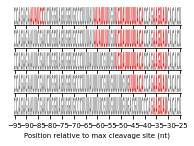

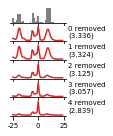

In [12]:
maxUA = 5
rs = 270637210
example_id = "011053:XV:397538:-"
example_iter = 68


## Print site information and cleavage entropy data

example_gene    = gold_tpdata.loc[gold_tpdata['label'] == example_id, 'gene'].iloc[0]
example_obsent  = gold_tpdata.loc[gold_tpdata['label'] == example_id, 'observed_entropy'].iloc[0]
example_maxclv  = gold_tpdata.loc[gold_tpdata['label'] == example_id, 'ctr_cleavage'].iloc[0]
example_readvec = gold_tpdata.loc[gold_tpdata['label'] == example_id, 'readvec'].iloc[0]
print(f"Gene={example_gene}, observed_entropy={example_obsent}")

example_bin0 = hi_mult_data.loc[(hi_mult_data['testID'] == example_id) & (hi_mult_data['iteration'] == 0)            & (hi_mult_data['count'] == maxUA)].sample(1, random_state = rs).iloc[0]
example_bin1 = hi_mult_data.loc[(hi_mult_data['testID'] == example_id) & (hi_mult_data['iteration'] == example_iter) & (hi_mult_data['count'] == maxUA-1)].sample(1, random_state = rs).iloc[0]
example_bin2 = hi_mult_data.loc[(hi_mult_data['testID'] == example_id) & (hi_mult_data['iteration'] == example_iter) & (hi_mult_data['count'] == maxUA-2)].sample(1, random_state = rs).iloc[0]
example_bin3 = hi_mult_data.loc[(hi_mult_data['testID'] == example_id) & (hi_mult_data['iteration'] == example_iter) & (hi_mult_data['count'] == maxUA-3)].sample(1, random_state = rs).iloc[0]
example_bin4 = hi_mult_data.loc[(hi_mult_data['testID'] == example_id) & (hi_mult_data['iteration'] == example_iter) & (hi_mult_data['count'] == maxUA-4)].sample(1, random_state = rs).iloc[0]

example_bin_max = max([max(x['cleavageVector']) for x in [example_bin0, example_bin1, example_bin2, example_bin3, example_bin4]])
print(f"Max normalized cleavage prediction: {example_bin_max}")

for e in [example_bin0, example_bin1, example_bin2, example_bin3, example_bin4]:
    print(e.name, e['sequence'][int(example_maxclv-95):int(example_maxclv-25)], e['cleavageEntropy'], e['count'], sorted(e['indices'].tolist()))

    
## Plot upstream nucleotide sequence

fig,axes = plt.subplots(5,1, figsize = (3,2), sharex = True, sharey = True)

xs = np.arange(-95,-24,1)

for ax,ex in zip(axes,[example_bin0, example_bin1, example_bin2, example_bin3, example_bin4]):
    
    ## plot sequence logo
    exseq = ex['sequence'][int(example_maxclv-95):int(example_maxclv-24)]
    encoding = cleavage.encode_sequence(exseq)
    seqmotif = pd.DataFrame(encoding, columns = ['A','C','G','U'], index = xs)

    logo = logomaker.Logo(seqmotif, ax = ax, width = 0.8, vpad = 0.05, color_scheme = {'A':'gray', 'U':'gray', 'G':'gray', 'C':'gray'})
    
    for i in ex['indices']:
        for j in np.arange(i,i+6,1):
            logo.style_single_glyph(int(j-example_maxclv), exseq[int(j-example_maxclv+95)].replace("T","U"), color = "#d62a28")

    ax.set_xticks(np.arange(-95,-24,5))
    ax.set_yticks([])
    
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
axes[-1].set_xlabel("Position relative to max cleavage site (nt)")

plt.savefig(os.path.join(OUTDIR, f'entropy_mechanisms.uaua_multiplicity.high_entropy.{example_id.replace(":","_")}.example_sequence.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


## Plot cleavage profile

fig,axes = plt.subplots(6,1, figsize = (1,2), sharex = True, sharey = False)

for i,(ax,ex) in enumerate(zip(axes, [example_readvec, example_bin0, example_bin1, example_bin2, example_bin3, example_bin4])):
    
    if (i == 0):
        ax.bar(np.arange(0,50,1), ex, width = 1, color = 'gray')
    else:
        ax.plot(ex['cleavageVector'], color = '#d62a28')
        ax.text(x=1.05, y=1, s=f"{maxUA-ex['count']} removed\n({ex['cleavageEntropy']:.03f})", transform = ax.transAxes, ha = 'left', va = 'top')

    ax.set_xticks(np.arange(0,51,25))
    ax.set_xticklabels(np.arange(-25,26,25))
    
    ax.set_yticks([])
#     ax.set_ylim(0,example_bin_max*1.1)

    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'entropy_mechanisms.uaua_multiplicity.high_entropy.{example_id.replace(":","_")}.example_cleavage.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


#### Example 3

Gene=YLR180W, observed_entropy=2.9487889547945203
Max normalized cleavage prediction: 0.20870600640773773
53607 ACAGGATTCCTTTTCCTTTCTAACATTTAATACGTAACTACTAATATTAATATATACCTCCTTCAACGGA 3.2124281360947577 5 [181.0, 189.0, 196.0, 202.0, 208.0]
54093 ACAGGATTCCTTTTCCTTTCTAACATTACGTTCGTAACTACTAATATTAATATATACCTCCTTCAACGGA 3.185277274833206 4 [189.0, 196.0, 202.0, 208.0]
54094 ACAGGATTCCTTTTCCTTTCTAACATTACGTTCGTCGATTCTAATATTAATATATACCTCCTTCAACGGA 2.9347323053336933 3 [196.0, 202.0, 208.0]
54095 ACAGGATTCCTTTTCCTTTCTAACATTACGTTCGTCGATTCAAAACTTAATATATACCTCCTTCAACGGA 2.8654759632397546 2 [202.0, 208.0]
54096 ACAGGATTCCTTTTCCTTTCTAACATTACGTTCGTCGATTCAAAACTTAGCGGATACCTCCTTCAACGGA 2.7585101338223774 1 [208.0]


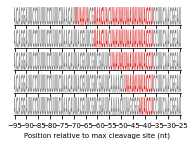

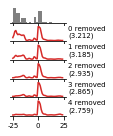

In [13]:
maxUA = 5
rs = 2297800644
example_id = "003651:XII:516678:+"
example_iter = 98


## Print site information and cleavage entropy data

example_gene    = gold_tpdata.loc[gold_tpdata['label'] == example_id, 'gene'].iloc[0]
example_obsent  = gold_tpdata.loc[gold_tpdata['label'] == example_id, 'observed_entropy'].iloc[0]
example_maxclv  = gold_tpdata.loc[gold_tpdata['label'] == example_id, 'ctr_cleavage'].iloc[0]
example_readvec = gold_tpdata.loc[gold_tpdata['label'] == example_id, 'readvec'].iloc[0]
print(f"Gene={example_gene}, observed_entropy={example_obsent}")

example_bin0 = hi_mult_data.loc[(hi_mult_data['testID'] == example_id) & (hi_mult_data['iteration'] == 0)            & (hi_mult_data['count'] == maxUA)].sample(1, random_state = rs).iloc[0]
example_bin1 = hi_mult_data.loc[(hi_mult_data['testID'] == example_id) & (hi_mult_data['iteration'] == example_iter) & (hi_mult_data['count'] == maxUA-1)].sample(1, random_state = rs).iloc[0]
example_bin2 = hi_mult_data.loc[(hi_mult_data['testID'] == example_id) & (hi_mult_data['iteration'] == example_iter) & (hi_mult_data['count'] == maxUA-2)].sample(1, random_state = rs).iloc[0]
example_bin3 = hi_mult_data.loc[(hi_mult_data['testID'] == example_id) & (hi_mult_data['iteration'] == example_iter) & (hi_mult_data['count'] == maxUA-3)].sample(1, random_state = rs).iloc[0]
example_bin4 = hi_mult_data.loc[(hi_mult_data['testID'] == example_id) & (hi_mult_data['iteration'] == example_iter) & (hi_mult_data['count'] == maxUA-4)].sample(1, random_state = rs).iloc[0]

example_bin_max = max([max(x['cleavageVector']) for x in [example_bin0, example_bin1, example_bin2, example_bin3, example_bin4]])
print(f"Max normalized cleavage prediction: {example_bin_max}")

for e in [example_bin0, example_bin1, example_bin2, example_bin3, example_bin4]:
    print(e.name, e['sequence'][int(example_maxclv-95):int(example_maxclv-25)], e['cleavageEntropy'], e['count'], sorted(e['indices'].tolist()))

    
## Plot upstream nucleotide sequence

fig,axes = plt.subplots(5,1, figsize = (3,2), sharex = True, sharey = True)

xs = np.arange(-95,-24,1)

for ax,ex in zip(axes,[example_bin0, example_bin1, example_bin2, example_bin3, example_bin4]):
    
    ## plot sequence logo
    exseq = ex['sequence'][int(example_maxclv-95):int(example_maxclv-24)]
    encoding = cleavage.encode_sequence(exseq)
    seqmotif = pd.DataFrame(encoding, columns = ['A','C','G','U'], index = xs)

    logo = logomaker.Logo(seqmotif, ax = ax, width = 0.8, vpad = 0.05, color_scheme = {'A':'gray', 'U':'gray', 'G':'gray', 'C':'gray'})
    
    for i in ex['indices']:
        for j in np.arange(i,i+6,1):
            logo.style_single_glyph(int(j-example_maxclv), exseq[int(j-example_maxclv+95)].replace("T","U"), color = "#d62a28")

    ax.set_xticks(np.arange(-95,-24,5))
    ax.set_yticks([])
    
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
axes[-1].set_xlabel("Position relative to max cleavage site (nt)")

plt.savefig(os.path.join(OUTDIR, f'entropy_mechanisms.uaua_multiplicity.high_entropy.{example_id.replace(":","_")}.example_sequence.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


## Plot cleavage profile

fig,axes = plt.subplots(6,1, figsize = (1,2), sharex = True, sharey = False)

for i,(ax,ex) in enumerate(zip(axes, [example_readvec, example_bin0, example_bin1, example_bin2, example_bin3, example_bin4])):
    
    if (i == 0):
        ax.bar(np.arange(0,50,1), ex, width = 1, color = 'gray')
    else:
        ax.plot(ex['cleavageVector'], color = '#d62a28')
        ax.text(x=1.05, y=1, s=f"{maxUA-ex['count']} removed\n({ex['cleavageEntropy']:.03f})", transform = ax.transAxes, ha = 'left', va = 'top')

    ax.set_xticks(np.arange(0,51,25))
    ax.set_xticklabels(np.arange(-25,26,25))
    
    ax.set_yticks([])
#     ax.set_ylim(0,example_bin_max*1.1)

    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'entropy_mechanisms.uaua_multiplicity.high_entropy.{example_id.replace(":","_")}.example_cleavage.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()
